In [1]:
from datasets import synthetic
from methods.ZSB import ZSBSensitivityAnalysis
from methods.QB import QBSensitivityAnalysis, get_quantile_regressor
from bootstrap import BootstrapSensitivityAnalysis
import numpy as np
from test import run_hypothesis_test

n_obs = 10000
n_rct = 1000
n_pop = 1000000
gamma_obs = 4.0
data_obs = synthetic.Synthetic(n_obs, gamma_obs, "pi")
e_x = lambda x: (1+np.exp(- (x*0.75+0.5)))** -1

x_rct, t_rct, y_rct, tau_rct = synthetic.create_RCT(num_examples=n_rct, seed=42)
x_pop, t_pop, y_pop, tau_pop = synthetic.create_RCT(num_examples=n_pop, seed=90)

print(f"Unconfounded Y(1): {(data_obs.t * data_obs.y/data_obs.pi).mean()/(data_obs.t /data_obs.pi).mean()}")
print(f"Confounded Y(1): {(data_obs.t * data_obs.y/e_x(data_obs.x)).mean()/(data_obs.t /e_x(data_obs.x)).mean()}")
print(f"RCT Y(1): {(y_rct[t_rct == 1]).mean()}")
print(f"True Y(1): {(y_pop[t_pop == 1]).mean()}")

Unconfounded Y(1): 1.0955791473388672
Confounded Y(1): 0.4113353490829468
RCT Y(1): 0.9614018201828003
True Y(1): 1.0047197341918945


In [4]:
gamma = 3.0
sa = ZSBSensitivityAnalysis(data_obs.x, data_obs.t, data_obs.y, e_x, gamma)
print(sa.solve_bounds())
bootstrap_sa = BootstrapSensitivityAnalysis(sa)
bounds_dist = bootstrap_sa.bootstrap(num_samples=1000, results_path = "results/synthetic")

(-0.6161494846267834, 1.0715911547338477)
Elapsed time for 1000 bootstrap samples: 24.29 seconds


In [5]:
run_hypothesis_test(y_rct=y_rct[t_rct == 1], bootstrap_sa=bootstrap_sa, alpha=5)

Accept null hypothesis: 18.40456602969037>-1.9599639845400545


In [6]:
tau = gamma / (gamma + 1)
ub_qr_func = get_quantile_regressor(data_obs.x[data_obs.t==1], data_obs.y[data_obs.t==1], tau)
lb_qr_func = get_quantile_regressor(data_obs.x[data_obs.t==1], data_obs.y[data_obs.t==1], 1-tau)
sa = QBSensitivityAnalysis(data_obs.x, data_obs.t, data_obs.y, e_x, gamma, lb_qr_func, ub_qr_func, False)
print(sa.solve_bounds())
bootstrap_sa = BootstrapSensitivityAnalysis(sa)
bounds_dist = bootstrap_sa.bootstrap(num_samples=1000, results_path = "results/synthetic")

Best Parameters (LightGBM): {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 1, 'learning_rate': 0.05}
Cross Validation Score (LightGBM): 0.8720742775168976
Best Parameters (Quantile Regressor): {'alpha': 0, 'fit_intercept': True}
Cross Validation Score (Quantile Regressor): 0.9633228859718862
Best Parameters (LightGBM): {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 5, 'learning_rate': 0.05}
Cross Validation Score (LightGBM): 0.637119632768017
Best Parameters (Quantile Regressor): {'alpha': 0, 'fit_intercept': True}
Cross Validation Score (Quantile Regressor): 0.8125691376545408
(-0.2706858990276605, 0.8475840461518687)
Elapsed time for 1000 bootstrap samples: 477.94 seconds


In [5]:
run_hypothesis_test(y_rct=y_rct[t_rct == 1], bootstrap_sa=bootstrap_sa, alpha=5)

Reject null hypothesis: -18.66670575268971<-1.9599639845400545


ZBS is a bit conservative, so even when underestimating gamma, the bounds are large enough to include the true Y(1). QB on the other hand is sharp, does not include the true Y(1) and thus we reject the null hypothesis with very high confidence

In [6]:
gamma = 4.0
tau = gamma / (gamma + 1)
ub_qr_func = get_quantile_regressor(data_obs.x[data_obs.t==1], data_obs.y[data_obs.t==1], tau)
lb_qr_func = get_quantile_regressor(data_obs.x[data_obs.t==1], data_obs.y[data_obs.t==1], 1-tau)
sa = QBSensitivityAnalysis(data_obs.x, data_obs.t, data_obs.y, e_x, gamma, lb_qr_func, ub_qr_func, False)
print(sa.solve_bounds())
bootstrap_sa = BootstrapSensitivityAnalysis(sa)
bounds_dist = bootstrap_sa.bootstrap(num_samples=1000, results_path = "/Users/javierabad/Documents/GitLab/robust-cate/results/synthetic")

Best Parameters (LightGBM): {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'learning_rate': 0.05}
Cross Validation Score (LightGBM): 0.7416668759350833
Best Parameters (Quantile Regressor): {'alpha': 0, 'fit_intercept': True}
Cross Validation Score (Quantile Regressor): 0.8298056337182824
Best Parameters (LightGBM): {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'learning_rate': 0.05}
Cross Validation Score (LightGBM): 0.5381028078797206
Best Parameters (Quantile Regressor): {'alpha': 0, 'fit_intercept': True}
Cross Validation Score (Quantile Regressor): 0.6918696702764239
[-0.3736451692242784, 0.9828841539952267]
Elapsed time for 1000 bootstrap samples: 490.30 seconds


In [11]:
run_hypothesis_test(y_rct=y_rct[t_rct == 1], bootstrap_sa=bootstrap_sa, alpha=5)

Accept null hypothesis: 3.545479332879854>-1.9599639845400545


This is a bit trickier. We correctly specified gamma = 4.0. The true Y(1) from the population (0.99966) is not included in the given interval but the one obtained from the small RCT (0.9614) is included. The test eventually accepts the null hypothesis (of course y_obs_upper_bound > y_rct and therefore the statistic is positive), which is not great, but maybe we just cant do better 

Note: true Y(1) is not included in the given interval, but it is included in the interval obtained after applying bootstrap to the bounds and getting the quantiles with alpha = 5%. See next cell

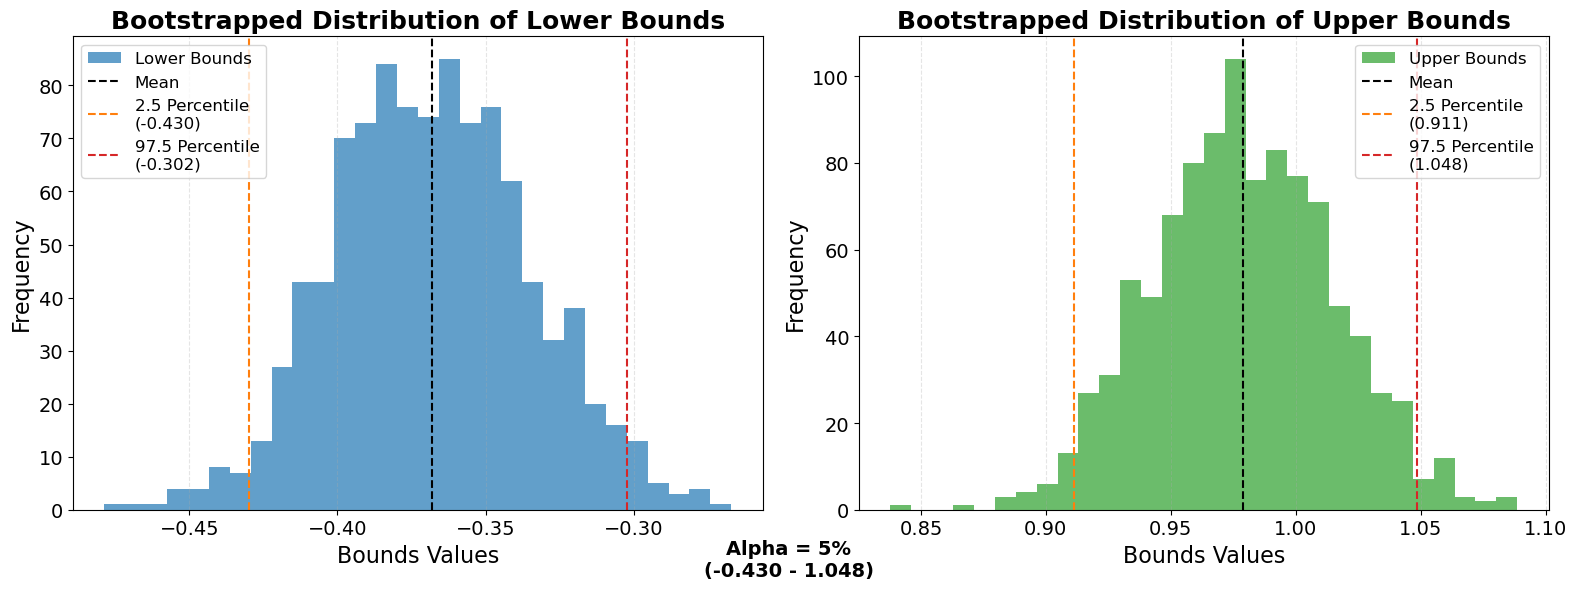

In [8]:
bootstrap_sa.plot_distribution(alpha=5)